In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from PIL import Image
from matplotlib.pyplot import imshow
import os
import pandas as pd

### Connect to gpu if available

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# cell to generate csv file that contains all image paths and labels
import pandas as pd
import os

dataset_df = pd.DataFrame(columns=["img_name","label"])

img_data_dir = './Task'
classes = os.listdir(img_data_dir)

i = 0;
for label in classes:  ## looping over each class

    class_path = img_data_dir + "/" + label  ## create the path of each image class

    files = os.listdir(class_path)  ## list of all files in each image class folder

    for file in files:  ## Enumerate over each image list
        dataset_df.loc[i] = [ os.path.join(class_path, file), ord(label) - ord('a')]
        i += 1
        
dataset_df.to_csv ('dataset_csv.csv', index = False, header=True)

### Set the root folder and dimensions of each image

In [11]:
root = "./Task"
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
image_length=128
image_width=128
number_of_classes=26

### Craete a class that inherits from  torch.utils.data.Dataset to load a custom data set

In [16]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, root, transform, annotation_file):
        """
        :param root: the directory where the dataset is.
        :param transform: transformation that is needed to be applied to data before it is loaded by DataLoader.
        :param annotation_file: csv file that holds the path and the label for each image.
        """
        self.root = root
        self.transform = transform
        self.annotations = pd.read_csv(annotation_file)

    def __len__(self):
        """
        :return: the length of dataset, the number of data in dataset
        """
        return len(self.annotations)

    def __getitem__(self, idx):
        """
        :param idx: index of data and corresponding label that we want to retrieve from dataset
        :return: x --> the tesnor image of that index, y --> the label of that index
        """
        path = self.annotations.iloc[idx, 0]
        img = Image.open(path).convert('L')  ## each the images from the folder. We are passing the file path + name in "imread"
        img = transform(img)
        x = img
        y = torch.tensor(self.annotations.iloc[idx, 1], dtype=torch.long)

        return x, y

### Declare the root folder and declare a new instance of the new class

In [17]:
dataset_file = './dataset_csv.csv'
dataset = MyDataset(root, transform, dataset_file)

### Split the data into train and validation sets,  create a data loader for each set

Label =  v


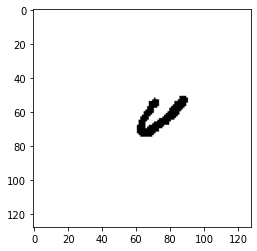

In [38]:
data_loader = torch.utils.data.DataLoader(dataset)

train_size = int(0.8 * len(data_loader))
val_size = len(data_loader) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

images, labels = next(iter(trainloader))

## show a sample image
print("Label = ", chr(labels[0] + ord('a')) )
imshow(transforms.ToPILImage()(images[0]), cmap='gray');

### Build the neural network model

In [19]:
input_size = image_width*image_width
hidden_sizes = [128, 64]
output_size = number_of_classes

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=16384, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=26, bias=True)
  (5): LogSoftmax(dim=1)
)


### Test if everything is working

In [21]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

### The train loop

In [22]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten images into a 128*128 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 1.670554875649003
Epoch 1 - Training loss: 1.003409009498598
Epoch 2 - Training loss: 0.8159402048316394
Epoch 3 - Training loss: 0.7249936859160923
Epoch 4 - Training loss: 0.6669126106279326
Epoch 5 - Training loss: 0.6180345008309585
Epoch 6 - Training loss: 0.5888698937309393
Epoch 7 - Training loss: 0.5674817070834691
Epoch 8 - Training loss: 0.5552426192080911
Epoch 9 - Training loss: 0.5313527806158033
Epoch 10 - Training loss: 0.5176496311317601
Epoch 11 - Training loss: 0.5080646556751531
Epoch 12 - Training loss: 0.49129337079549
Epoch 13 - Training loss: 0.4848606320792865
Epoch 14 - Training loss: 0.4751515891500822

Training Time (in minutes) = 77.5621245265007


### Perfrom a prediction on a sample image

In [23]:
images, labels = next(iter(valloader))

img = images[0].view(1, image_length*image_width)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)), "label =", labels[0].item())

Predicted Digit = 17 label = tensor(17)


### save the model for later use

In [24]:
torch.save(model, './my_model.pt') 

### Validate the model

In [69]:
pred_labels = []
true_labels = []

for images,labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, image_length*image_width)
        with torch.no_grad():
            logps = model(img)

        ps = torch.exp(logps)
        pred_labels.append(ps.argmax().item())
        true_labels.append(labels[i].item())

### Report Model Metrics

In [75]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1026
           1       0.90      0.92      0.91       988
           2       0.81      0.92      0.86       584
           3       0.91      0.93      0.92       970
           4       0.94      0.90      0.92      1015
           5       0.83      0.89      0.86       510
           6       0.77      0.60      0.68       774
           7       0.89      0.87      0.88       981
           8       0.74      0.61      0.67       521
           9       0.94      0.62      0.75       400
          10       0.77      0.87      0.82       496
          11       0.84      0.96      0.90      1043
          12       0.97      0.90      0.93       534
          13       0.88      0.94      0.91       978
          14       0.86      0.90      0.88       553
          15       0.82      0.90      0.86       465
          16       0.57      0.81      0.67       589
          17       0.92    

### References that helped me through the task
- https://medium.com/analytics-vidhya/implementing-cnn-in-pytorch-with-custom-dataset-and-transfer-learning-1864daac14cc
- https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627